Bibliothèques

In [1]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
!pip install -U scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
!pip install lime
from lime import lime_tabular
import xgboost

Data

In [6]:
ticket_data = pd.read_csv('ticket_data.csv')
cities = pd.read_csv('cities.csv')
stations = pd.read_csv('stations.csv')
providers = pd.read_csv('providers.csv')

In [8]:
# Personnaliser l'affichage des DataFrames
pd.options.display.max_columns = None
pd.options.display.width = None
pd.options.display.max_colwidth = -1

# Afficher les 5 premières lignes de chaque DataFrame
print("Les 5 premières lignes de ticket_data :")
display(ticket_data.head().style.hide_index())

print("\nLes 5 premières lignes de cities :")
display(cities.head().style.hide_index())

print("\nLes 5 premières lignes de stations :")
display(stations.head().style.hide_index())

print("\nLes 5 premières lignes de providers :")
display(providers.head().style.hide_index())

Les 5 premières lignes de ticket_data :


C:\Users\noure\AppData\Local\Temp\ipykernel_17992\341611132.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.options.display.max_colwidth = -1
C:\Users\noure\AppData\Local\Temp\ipykernel_17992\341611132.py:8: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  display(ticket_data.head().style.hide_index())


id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
6795025,8385,nan,nan,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,nan,nan,611,542
6795026,9,63.000000,1044.000000,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
6795027,8377,5905.000000,6495.000000,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
6795028,8377,5905.000000,6495.000000,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
6795029,8381,5905.000000,6495.000000,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542



Les 5 premières lignes de cities :


C:\Users\noure\AppData\Local\Temp\ipykernel_17992\341611132.py:11: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  display(cities.head().style.hide_index())


id,local_name,unique_name,latitude,longitude,population
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.000000
76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.000000
81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,nan
259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.000000
11979,"Balș, Olt, România",balș,44.353354,24.095672,nan



Les 5 premières lignes de stations :


C:\Users\noure\AppData\Local\Temp\ipykernel_17992\341611132.py:14: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  display(stations.head().style.hide_index())


id,unique_name,latitude,longitude
1,Aalen (Stuttgarter Straße),48.835296,10.092956
2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
3,Aéroport CDG,49.009900,2.559310
4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
5,Aéroport de Dresden,51.123604,13.764737



Les 5 premières lignes de providers :


C:\Users\noure\AppData\Local\Temp\ipykernel_17992\341611132.py:17: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  display(providers.head().style.hide_index())


id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
9,1,nan,ouibus,Ouibus,True,True,True,False,bus
10,2,nan,deinbus,Deinbus.de,False,False,False,False,bus
11,3,nan,infobus,Infobus,False,False,False,False,bus
12,4,nan,studentAgency,Student Agency,False,False,False,False,bus
13,5,nan,flixbus,Flixbus,True,False,False,False,bus


In [9]:
# Création d'un nouveau DataFrame tickets qui réunit toutes les données
tickets = ticket_data


In [10]:
# Remplacement des IDs des stations par leur nom, leur latitude et longitude.

station_cols = ['unique_name', 'latitude', 'longitude']
progress = 0
n,_ = tickets.shape
station_data = []

#Traitement des o_stations
print('o_station')
for p,o_station in enumerate(tickets['o_station']) :
    if p*100//n > progress :
        progress += 10
    station_line = stations[stations['id']==o_station]
    if station_line['id'].isnull().all() == False :
        station_data.append(station_line[station_cols].values.tolist()[0])
    else :
        station_data.append([None, None, None])
        
for i,col in enumerate(station_cols) :
    tickets['o_station : '+col] = np.array(station_data)[:,i]
tickets.drop(['o_station'], axis=1, inplace=True)

#Traitement des d_stations
progress = 0
station_data = []
print('d-station')
for p,d_station in enumerate(tickets['d_station']) :
    if p*100//n > progress :
        progress += 10
    station_line = stations[stations['id']==d_station]
    if station_line['id'].isnull().all() == False :
        station_data.append(station_line[station_cols].values.tolist()[0])
    else :
        station_data.append([None, None, None])
        
for i,col in enumerate(station_cols) :
    tickets['d_station : '+col] = np.array(station_data)[:,i]
tickets.drop(['d_station'], axis=1, inplace=True)

tickets.head()

o_station
d-station


,id,company,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,o_station : unique_name,o_station : latitude,o_station : longitude,d_station : unique_name,d_station : latitude,d_station : longitude
0,6795025,8385,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,None,None,None,None,None,None
1,6795026,9,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,Avenue Georges Pompidou,47.896911,1.854277,Station Les Sabines,43.583932,3.860233
2,6795027,8377,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805
3,6795028,8377,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805
4,6795029,8381,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805


In [11]:
# Remplacement des IDs de cities par leur nom, leur latitude, leur longitiude et la population

city_cols = ['unique_name', 'latitude', 'longitude', 'population']
progress = 0
n,_ = tickets.shape
city_data = []

#Traitement des o_stations
for p,o_city in enumerate(tickets['o_city']) :
    if p*100//n > progress :
        progress += 5
    city_line = cities[cities['id']==o_city]
    if city_line['id'].isnull().all() == False :
        city_data.append(city_line[city_cols].values.tolist()[0])
    else :
        city_data.append([None, None, None, None])
        
for i,col in enumerate(city_cols) :
    tickets['o_city : '+col] = np.array(city_data)[:,i]
tickets.drop(['o_city'], axis=1, inplace=True)

#Traitement des d_stations
progress = 0
city_data = []
for p,d_city in enumerate(tickets['d_city']) :
    if p*100//n > progress :
        progress += 5
    city_line = cities[cities['id']==d_city]
    if city_line['id'].isnull().all() == False :
        city_data.append(city_line[city_cols].values.tolist()[0])
    else :
        city_data.append([None, None, None, None])
        
for i,col in enumerate(city_cols) :
    tickets['d_city : '+col] = np.array(city_data)[:,i]
tickets.drop(['d_city'], axis=1, inplace=True)

tickets.head()

,id,company,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_station : unique_name,o_station : latitude,o_station : longitude,d_station : unique_name,d_station : latitude,d_station : longitude,o_city : unique_name,o_city : latitude,o_city : longitude,o_city : population,d_city : unique_name,d_city : latitude,d_city : longitude,d_city : population
0,6795025,8385,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,None,None,None,None,None,None,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0
1,6795026,9,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},Avenue Georges Pompidou,47.896911,1.854277,Station Les Sabines,43.583932,3.860233,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0
2,6795027,8377,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0
3,6795028,8377,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0
4,6795029,8381,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0


In [12]:
# Remplacement des IDs de companies par leur nom, leur type de transports et des propriétés.

company_cols = ['fullname', 'has_wifi', 'has_plug', 'has_adjustable_seats', 'has_bicycle', 'transport_type']
progress = 0
company_data = []

#Traitement des companies
print('companies')
for p,company in enumerate(tickets['company']) :
    if p*100//n > progress :
        progress += 10
    company_line = providers[providers['id']==company]
    if company_line['id'].isnull().all() == False :
        company_data.append(company_line[company_cols].values.tolist()[0])
    else :
        company_data.append([None, None, None, None, None, None])
        
for i,col in enumerate(company_cols) :
    tickets['company : '+col] = np.array(company_data)[:,i]
tickets.drop(['company'], axis=1, inplace=True)

tickets.head()

companies


,id,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_station : unique_name,o_station : latitude,o_station : longitude,d_station : unique_name,d_station : latitude,d_station : longitude,o_city : unique_name,o_city : latitude,o_city : longitude,o_city : population,d_city : unique_name,d_city : latitude,d_city : longitude,d_city : population,company : fullname,company : has_wifi,company : has_plug,company : has_adjustable_seats,company : has_bicycle,company : transport_type
0,6795025,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,None,None,None,None,None,None,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Blablacar,False,False,False,False,carpooling
1,6795026,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},Avenue Georges Pompidou,47.896911,1.854277,Station Les Sabines,43.583932,3.860233,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Ouibus,True,True,True,False,bus
2,6795027,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Intercités,False,False,True,False,train
3,6795028,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Intercités,False,False,True,False,train
4,6795029,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Intercités de Nuit,False,False,True,False,train


In [13]:
# Transformation des middles_stations et other_companies de la forme {149,418} en liste de nombres
def decompone(string):
    s = string.strip("{}")
    S = s.split(',')
    L = []
    for l in S :
        new_l = float(l)
        # Suppression des doublons
        if new_l not in L :
            L.append(float(l))
    return L

In [14]:
# Rajout des stations et des companies intermédiaires

# Il faut d'abord connaitre le nombre maximal d'autre station et d'autres companies pour rajouter le bon nombre de colonnes
L = [len(decompone(i)) for i in tickets['middle_stations'].unique() if type(i) != float]
l_max = max(L)

N = [len(decompone(i)) for i in tickets['other_companies'].unique() if type(i) != float]
n_max = max(N)

print(l_max, n_max)

# Création des listes intermédiaires des nombres de la bonne taille
list_middle_stations = []
for i in tickets['middle_stations']: 
    if type(i) == float :
        list_middle_stations.append([None, None, None, None, None, 0])
    else :
        lms = decompone(i)
        n_lms = len(lms)
        for _ in range(l_max-len(lms)) :
            lms.append(None)
        list_middle_stations.append(lms+[n_lms])

list_other_companies = []
for i in tickets['other_companies']: 
    if type(i) == float :
        list_other_companies.append([None, None, None, 0])
    else : 
        loc = decompone(i)
        n_loc = len(loc)
        for _ in range(n_max-len(loc)) :
            loc.append(None)
        list_other_companies.append(loc+[n_loc])

# Création des dataframes
middles_stations_cols = ['middles_stations '+str(i) for i in range(1,l_max+1)] + ['number_middles_stations']
other_companies_cols  = ['other_comanies '+str(i) for i in range(1,n_max+1)] + ['number_other_companies']

for i,col in enumerate(middles_stations_cols):
    tickets[col] = np.array(list_middle_stations)[:,i]

for i,col in enumerate(other_companies_cols):
    tickets[col] = np.array(list_other_companies)[:,i]
    
# On supprime les colonnes de bases
tickets.drop('middle_stations', axis=1, inplace=True)
tickets.drop('other_companies', axis=1, inplace=True)

5 3


In [15]:
# Rajout de la durée du trajet
duree = []
classe = []
for i in range(n):
    departure_time = parse(tickets['departure_ts'].iloc[i])
    arrival_time   = parse(tickets['arrival_ts'].iloc[i])
    
    delta = arrival_time-departure_time
    t = pd.to_timedelta(delta).value*10**-11
    
    classe_temps = ''
    if t < 50 :
        classe_temps = 'tres_court'
    elif t < 100 :
        classe_temps = 'court'
    elif t < 200 :
        classe_temps = 'moyen'
    elif t < 400 :
        classe_temps = 'long'
    elif t < 800 :
        classe_temps = 'tres_long'
    else :
        classe_temps = 'tres_tres_long'
    
    classe.append(classe_temps)
    duree.append(delta)

tickets['duree_trajet'] = duree
tickets['classe_duree_trajet'] = classe

In [16]:
# Rajout de la distance grossière du trajet et classification pour un regroupement futur
distance = []
classe = []
for i in range(n):
    o_lat = float(tickets['o_city : latitude'].iloc[i])*np.pi/180
    o_lng = float(tickets['o_city : longitude'].iloc[i])*np.pi/180
    d_lat = float(tickets['d_city : latitude'].iloc[i])*np.pi/180
    d_lng = float(tickets['d_city : longitude'].iloc[i])*np.pi/180
    
    # méthode haversine
    a = np.sin((d_lat-o_lat)/2)**2 + np.cos(o_lat)*np.cos(d_lat)*(np.sin((d_lng-o_lng)/2)**2)
    c = 2*np.arctan2(a**0.5, (1-a)**0.5)
    R = 6378
    d = R*c
    
    classe_distance = ''
    if d < 200 :
        classe_distance = 'court'
    elif d < 800 :
        classe_distance = 'moyen'
    elif d < 2000 :
        classe_distance = 'long'
    else :
        classe_distance = 'tres_long'
        
    distance.append(d)
    classe.append(classe_distance)
    
tickets['distance_trajet (km)'] = distance
tickets['classe_distance'] = classe

tickets.head()

,id,departure_ts,arrival_ts,price_in_cents,search_ts,o_station : unique_name,o_station : latitude,o_station : longitude,d_station : unique_name,d_station : latitude,d_station : longitude,o_city : unique_name,o_city : latitude,o_city : longitude,o_city : population,d_city : unique_name,d_city : latitude,d_city : longitude,d_city : population,company : fullname,company : has_wifi,company : has_plug,company : has_adjustable_seats,company : has_bicycle,company : transport_type,middles_stations 1,middles_stations 2,middles_stations 3,middles_stations 4,middles_stations 5,number_middles_stations,other_comanies 1,other_comanies 2,other_comanies 3,number_other_companies,duree_trajet,classe_duree_trajet,distance_trajet (km),classe_distance
0,6795025,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,None,None,None,None,None,None,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Blablacar,False,False,False,False,carpooling,None,None,None,None,None,0,None,None,None,0,0 days 06:10:00,long,503.750044,moyen
1,6795026,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,Avenue Georges Pompidou,47.896911,1.854277,Station Les Sabines,43.583932,3.860233,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Ouibus,True,True,True,False,bus,149.0,418.0,None,None,None,2,13.0,None,None,1,0 days 17:50:00,tres_long,503.750044,moyen
2,6795027,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Intercités,False,False,True,False,train,798.0,6794.0,6246.0,None,None,3,8377.0,8376.0,None,2,1 days 07:57:00,tres_tres_long,503.750044,moyen
3,6795028,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Intercités,False,False,True,False,train,798.0,6794.0,6246.0,None,None,3,8377.0,8376.0,None,2,0 days 21:35:00,tres_long,503.750044,moyen
4,6795029,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,Les Aubrais,47.92674,1.90674,Montpellier,43.6049,3.8805,orleans,47.907018,1.90627,114977.0,montpellier,43.604452,3.918318,275318.0,Intercités de Nuit,False,False,True,False,train,5983.0,None,None,None,None,1,8380.0,None,None,1,0 days 21:46:00,tres_long,503.750044,moyen


Exploration des données

In [17]:
print(tickets.head())
print(tickets.shape)
print(tickets.columns)

        id            departure_ts              arrival_ts  price_in_cents  \
0  6795025  2017-10-13 14:00:00+00  2017-10-13 20:10:00+00  4550             
1  6795026  2017-10-13 13:05:00+00  2017-10-14 06:55:00+00  1450             
2  6795027  2017-10-13 13:27:00+00  2017-10-14 21:24:00+00  7400             
3  6795028  2017-10-13 13:27:00+00  2017-10-14 11:02:00+00  13500            
4  6795029  2017-10-13 21:46:00+00  2017-10-14 19:32:00+00  7710             

                    search_ts  o_station : unique_name o_station : latitude  \
0  2017-10-01 00:13:31.327+00  None                     None                  
1  2017-10-01 00:13:35.773+00  Avenue Georges Pompidou  47.896911             
2  2017-10-01 00:13:40.212+00  Les Aubrais              47.92674              
3  2017-10-01 00:13:40.213+00  Les Aubrais              47.92674              
4  2017-10-01 00:13:40.213+00  Les Aubrais              47.92674              

  o_station : longitude d_station : unique_name d_statio

In [18]:
print("Nombre de valeurs manquantes dans tickets :\n", tickets.isnull().sum())
print("Nombre de doublons dans tickets :\n", tickets.duplicated().sum())

Nombre de valeurs manquantes dans tickets :
 id                                0    
departure_ts                      0    
arrival_ts                        0    
price_in_cents                    0    
search_ts                         0    
o_station : unique_name           41441
o_station : latitude              41441
o_station : longitude             41441
d_station : unique_name           41441
d_station : latitude              41441
d_station : longitude             41441
o_city : unique_name              0    
o_city : latitude                 0    
o_city : longitude                0    
o_city : population               0    
d_city : unique_name              0    
d_city : latitude                 0    
d_city : longitude                0    
d_city : population               0    
company : fullname                0    
company : has_wifi                0    
company : has_plug                0    
company : has_adjustable_seats    0    
company : has_bicycle             0

Analyse des données

In [19]:
tickets['price_in_cents'].describe()

count    74168.000000
mean     4382.711061 
std      3739.325367 
min      300.000000  
25%      1900.000000 
50%      3350.000000 
75%      5250.000000 
max      38550.000000
Name: price_in_cents, dtype: float64

In [20]:
tickets['duree_trajet'].describe()

count    74168                    
mean     0 days 07:04:37.247600043
std      0 days 09:54:58.881351022
min      0 days 00:20:00          
25%      0 days 03:00:00          
50%      0 days 04:50:00          
75%      0 days 08:00:00          
max      20 days 12:51:00         
Name: duree_trajet, dtype: object

In [21]:
tickets.groupby(['company : transport_type'])['duree_trajet'].describe()

,count,mean,std,min,25%,50%,75%,max
company : transport_type,,,,,,,,
bus,13798,0 days 15:37:59.769531816,0 days 18:56:55.117730352,0 days 01:05:00,0 days 09:10:00,0 days 12:40:00,0 days 18:28:45,20 days 12:51:00
carpooling,41441,0 days 04:06:38.330156125,0 days 02:08:46.903503480,0 days 00:20:00,0 days 02:30:00,0 days 03:40:00,0 days 05:10:00,1 days 05:10:00
train,18929,0 days 07:20:03.435997675,0 days 06:23:16.390907851,0 days 00:39:00,0 days 03:35:00,0 days 05:11:00,0 days 07:48:00,2 days 00:27:00


In [22]:
tickets.groupby(['company : transport_type'])['price_in_cents'].describe()

,count,mean,std,min,25%,50%,75%,max
company : transport_type,,,,,,,,
bus,13798.0,3652.448036,1913.197779,850.0,2390.0,3300.0,4400.0,22900.0
carpooling,41441.0,2742.171907,1501.934054,300.0,1550.0,2500.0,3600.0,16150.0
train,18929.0,8506.634793,4888.064503,490.0,4800.0,7540.0,11200.0,38550.0


In [23]:
tickets.groupby(['classe_distance'])['price_in_cents'].describe()

,count,mean,std,min,25%,50%,75%,max
classe_distance,,,,,,,,
court,13724.0,1678.972311,1340.887966,300.0,950.0,1300.0,1800.0,25100.0
long,1567.0,8857.869177,5008.885867,1940.0,5500.0,7780.0,10050.0,37550.0
moyen,58877.0,4893.836592,3745.577272,850.0,2500.0,3600.0,5800.0,38550.0


Visualisation des données

In [24]:
# Pour une meilleur visualisation, transformons la colonne price_in_cent en euros
tickets['price_in_cents'] *= 0.01

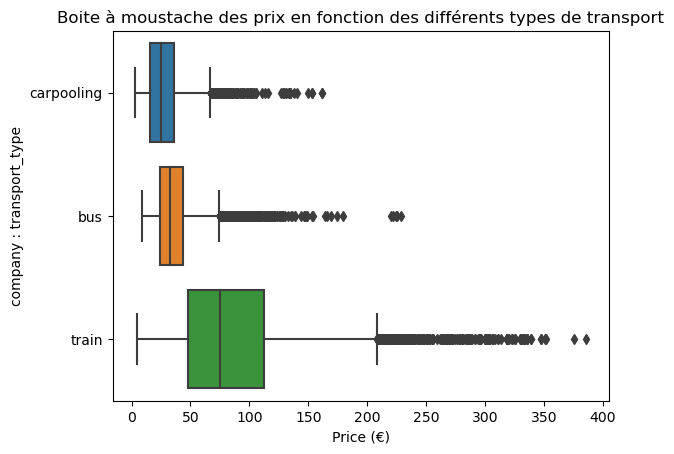

In [25]:
sns.boxplot(x=tickets['price_in_cents'], y=tickets['company : transport_type'])
plt.xlabel("Price (€)")
plt.title('Boite à moustache des prix en fonction des différents types de transport')
plt.show()

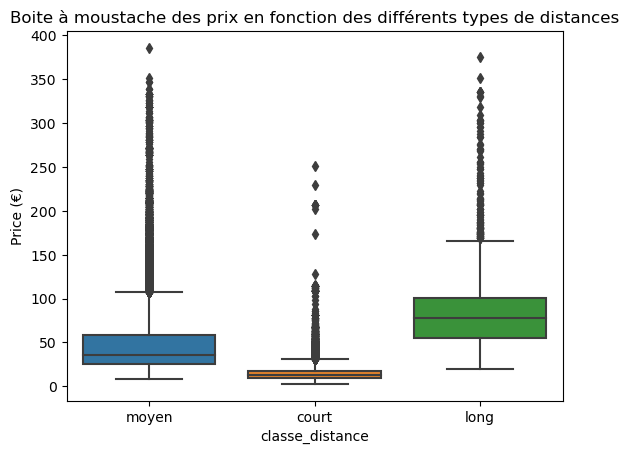

In [26]:
sns.boxplot(x='classe_distance', y='price_in_cents', data=tickets)
plt.ylabel("Price (€)")
plt.title('Boite à moustache des prix en fonction des différents types de distances')
plt.show()

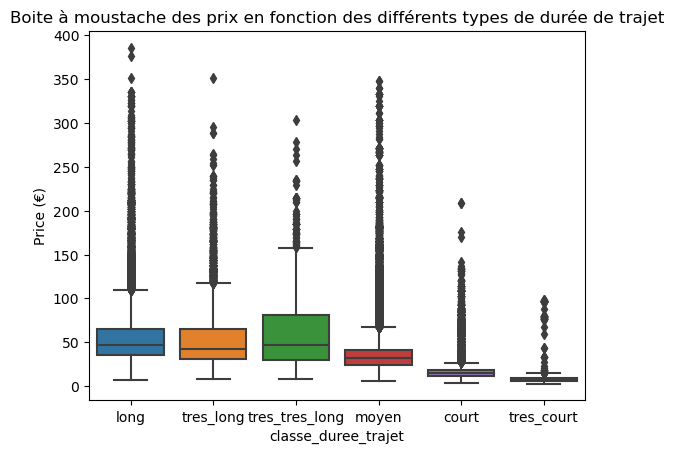

In [27]:
sns.boxplot(x='classe_duree_trajet', y='price_in_cents', data=tickets)
plt.ylabel("Price (€)")
plt.title('Boite à moustache des prix en fonction des différents types de durée de trajet')
plt.show()

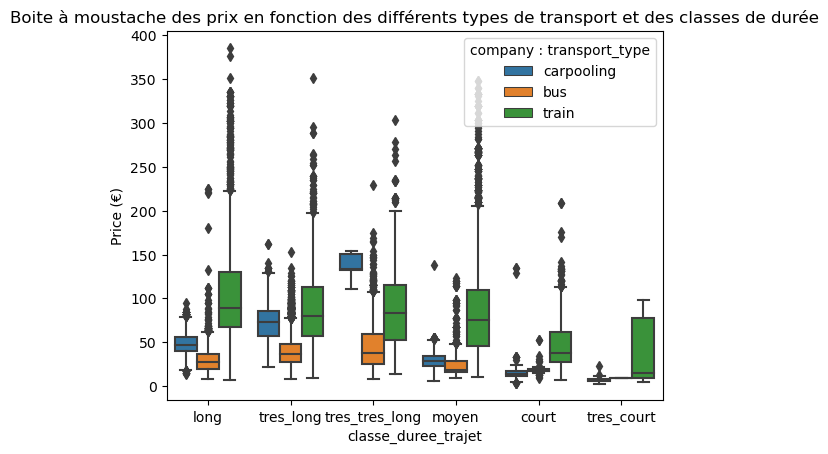

In [28]:
sns.boxplot(x='classe_duree_trajet', y='price_in_cents', hue='company : transport_type', data=tickets)
plt.ylabel("Price (€)")
plt.title('Boite à moustache des prix en fonction des différents types de transport et des classes de durée')
plt.show()

C:\Users\noure\AppData\Local\Temp\ipykernel_17992\444749517.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tickets['price_in_cents'])


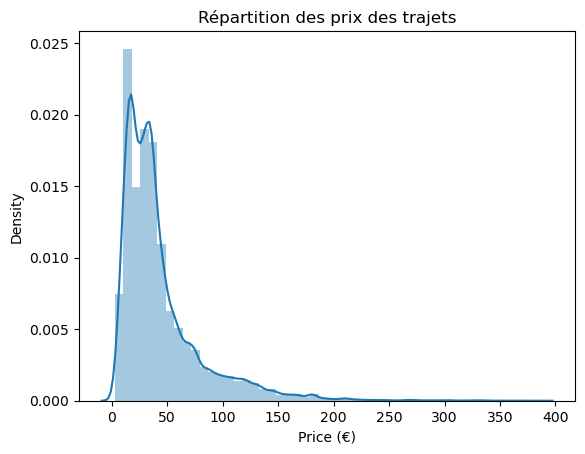

In [29]:
sns.distplot(tickets['price_in_cents'])
plt.xlabel('Price (€)')
plt.title('Répartition des prix des trajets')
plt.show()

C:\Users\noure\AppData\Local\Temp\ipykernel_17992\2023753880.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tickets['distance_trajet (km)'])


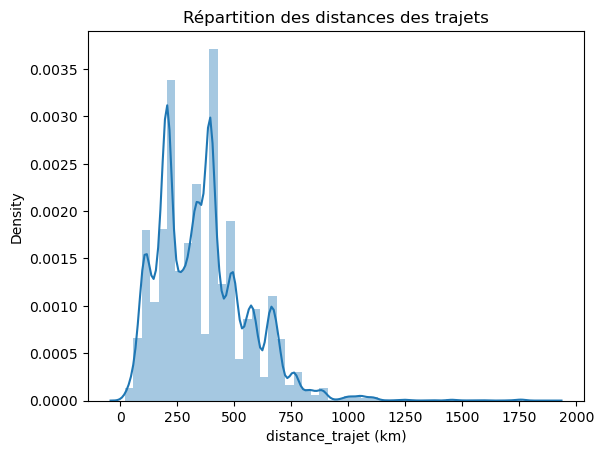

In [30]:
sns.distplot(tickets['distance_trajet (km)'])
plt.title('Répartition des distances des trajets')
plt.show()

Modélisation du prix

In [31]:
# Choix des colonnes utiles
saved_cols = ['price_in_cents', 'o_city : unique_name', 'o_city : population',
       'd_city : unique_name', 'd_city : population', 'company : fullname', 'company : has_wifi',
       'company : has_plug', 'company : has_adjustable_seats',
       'company : has_bicycle', 'company : transport_type', 'number_middles_stations',
       'number_other_companies', 'distance_trajet (km)', 'classe_distance',
       'duree_trajet', 'classe_duree_trajet']

df = tickets[saved_cols]
df.head()

,price_in_cents,o_city : unique_name,o_city : population,d_city : unique_name,d_city : population,company : fullname,company : has_wifi,company : has_plug,company : has_adjustable_seats,company : has_bicycle,company : transport_type,number_middles_stations,number_other_companies,distance_trajet (km),classe_distance,duree_trajet,classe_duree_trajet
0,45.5,orleans,114977.0,montpellier,275318.0,Blablacar,False,False,False,False,carpooling,0,0,503.750044,moyen,0 days 06:10:00,long
1,14.5,orleans,114977.0,montpellier,275318.0,Ouibus,True,True,True,False,bus,2,1,503.750044,moyen,0 days 17:50:00,tres_long
2,74.0,orleans,114977.0,montpellier,275318.0,Intercités,False,False,True,False,train,3,2,503.750044,moyen,1 days 07:57:00,tres_tres_long
3,135.0,orleans,114977.0,montpellier,275318.0,Intercités,False,False,True,False,train,3,2,503.750044,moyen,0 days 21:35:00,tres_long
4,77.1,orleans,114977.0,montpellier,275318.0,Intercités de Nuit,False,False,True,False,train,1,1,503.750044,moyen,0 days 21:46:00,tres_long


In [32]:
# Encodage des données
encodage = 'label'

# All categorical columns
object_cols = [col for col in df.columns if df[col].dtype == "object"]

if encodage == 'label' :
    # Label Encoding
    labelencoder = LabelEncoder()
    
    for col in object_cols :
        df[col] = labelencoder.fit_transform(df[col])

elif encodage == 'OneHot':
    # One Hot Encoding
    # Apply one-hot encoder to each column with categorical data
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))

    ### Drop categorical columns that will not be encoded
    df = df.drop(object_cols, axis=1)

    # One-hot encoding removed index; put it back
    OH_cols.index = df.index

    # Rajout des noms des nouvelles colonnes
    cols_encoding_name = []
    for index, col in enumerate(OH_encoder.categories_) :
        cols_encoding_name.extend([object_cols[index]+" "+str(c) for c in col])
    OH_cols.columns = cols_encoding_name

    df[cols_encoding_name] = OH_cols
    
df.head()

C:\Users\noure\AppData\Local\Temp\ipykernel_17992\2652826430.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = labelencoder.fit_transform(df[col])
C:\Users\noure\AppData\Local\Temp\ipykernel_17992\2652826430.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = labelencoder.fit_transform(df[col])
C:\Users\noure\AppData\Local\Temp\ipykernel_17992\2652826430.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,price_in_cents,o_city : unique_name,o_city : population,d_city : unique_name,d_city : population,company : fullname,company : has_wifi,company : has_plug,company : has_adjustable_seats,company : has_bicycle,company : transport_type,number_middles_stations,number_other_companies,distance_trajet (km),classe_distance,duree_trajet,classe_duree_trajet
0,45.5,207,7,219,57,0,0,0,0,0,1,0,0,503.750044,2,0 days 06:10:00,1
1,14.5,207,7,219,57,14,1,1,1,0,0,2,1,503.750044,2,0 days 17:50:00,4
2,74.0,207,7,219,57,8,0,0,1,0,2,3,2,503.750044,2,1 days 07:57:00,5
3,135.0,207,7,219,57,8,0,0,1,0,2,3,2,503.750044,2,0 days 21:35:00,4
4,77.1,207,7,219,57,9,0,0,1,0,2,1,1,503.750044,2,0 days 21:46:00,4


C:\Users\noure\AppData\Local\Temp\ipykernel_17992\732096913.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
C:\Users\noure\AppData\Local\Temp\ipykernel_17992\732096913.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


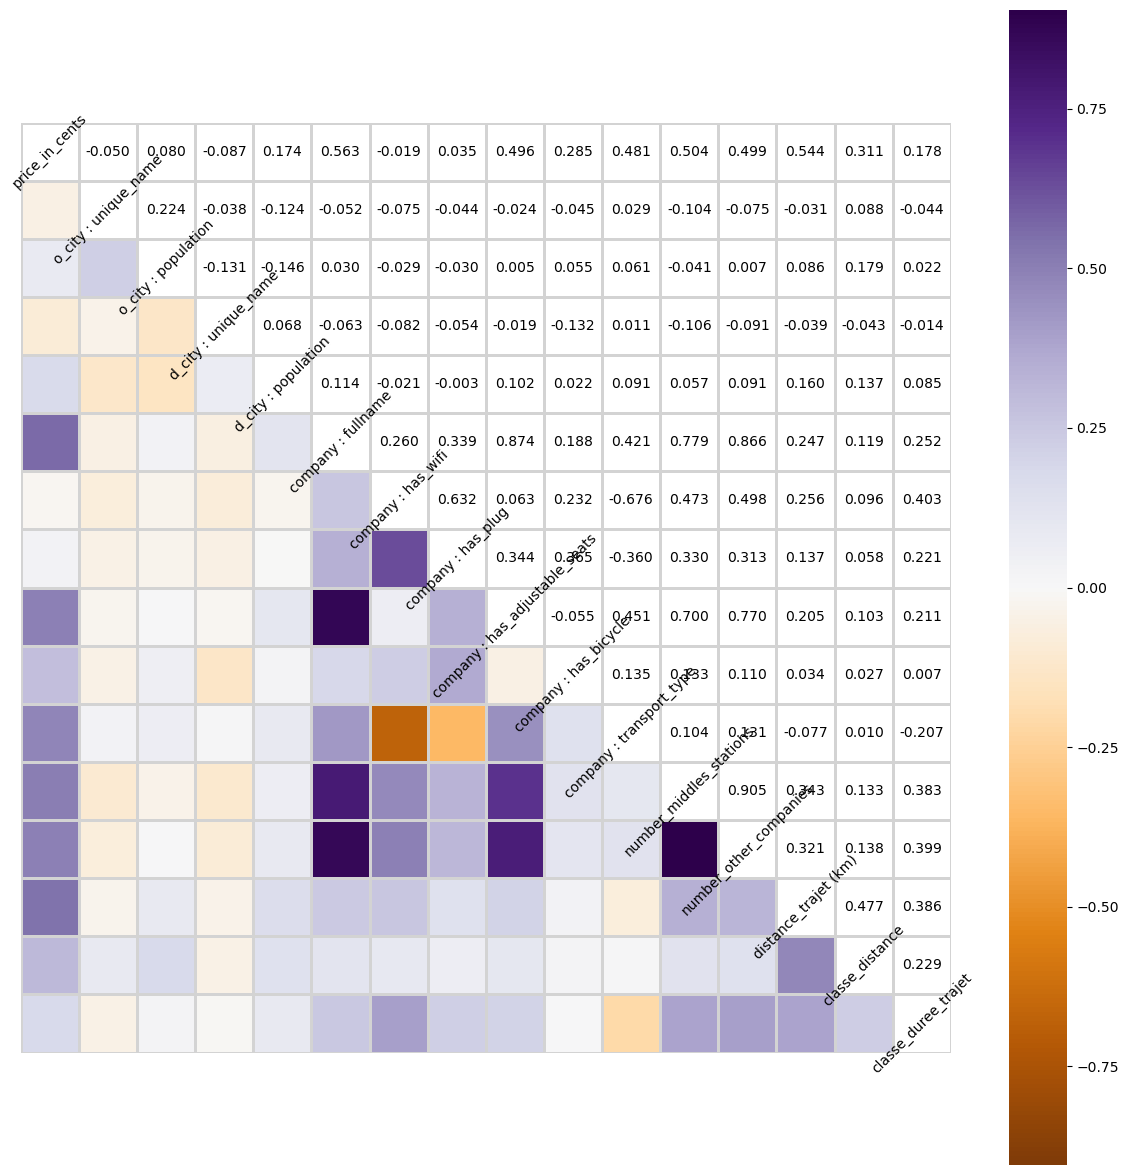

In [33]:
# Premiere visualisation des corrélations


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15,15))

# Draw the heatmap with the mask and correct aspect ratio
vmax = np.abs(corr.values[~mask]).max()
sns.heatmap(corr, mask=mask, cmap=plt.cm.PuOr, vmin=-vmax, vmax=vmax,
            square=True, linecolor="lightgray", linewidths=1, ax=ax)
for i in range(len(corr)):
    ax.text(i+0.5,(i+0.5), corr.columns[i], 
            ha="center", va="center", rotation=45)
    for j in range(i+1, len(corr)):
        s = "{:.3f}".format(corr.values[i,j])
        ax.text(j+0.5,(i+0.5),s, 
            ha="center", va="center")
ax.axis("off")

plt.show()

Test de prédiction



In [34]:
#Traitement des Nan restant par la technique des valeurs moyennes
df.fillna(value=df.mean(), inplace=True)

C:\Users\noure\AppData\Local\Temp\ipykernel_17992\2305102013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(value=df.mean(), inplace=True)
C:\Users\noure\AppData\Local\Temp\ipykernel_17992\2305102013.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.fillna(value=df.mean(), inplace=True)


In [35]:
#Splitting data

# Break off validation set from training data
y = df['price_in_cents']
X = df.drop(['price_in_cents'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8,
                                                      test_size=0.2, random_state=0)

In [40]:
import statsmodels
!pip install patsy
import patsy

## Test de prédiction

In [40]:
#Traitement des Nan restant par la technique des valeurs moyennes
df.fillna(value=df.mean(), inplace=True)

C:\Users\flore\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [41]:
#Splitting data

# Break off validation set from training data
y = df['price_in_cents']
X = df.drop(['price_in_cents'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8,
                                                      test_size=0.2, random_state=0)

### Regréssion Linéaire

In [60]:
# Création et entrainement du modèle de régression linéaire
model_linear = LinearRegression(normalize=True, n_jobs=4)
model_linear.fit(X_train, y_train)
print(model_linear.score(X_valid, y_valid))
print(model_linear.score(X_train, y_train))
print(0.01*MAE(y_valid, model_linear.predict(X_valid)))

0.7341068730941595
0.7236968097611902
11.079608895075769


In [64]:
alphas = 10**np.linspace(10,-2,100)*0.5
lassocv = LassoCV(alphas=alphas, cv=10, normalize=True, max_iter=10**4)
lassocv.fit(scale(X_train), y_train)
alpha = lassocv.alpha_
print(alpha)

0.005


In [66]:
model_lasso = Lasso(max_iter=10000, normalize=True)
model_lasso.set_params(alpha=alpha)
model_lasso.fit(scale(X_train), y_train)
print(model_lasso.score(scale(X_train), y_train))
print(model_lasso.score(scale(X_valid), y_valid))

0.723687310621532
0.7343168278661902


In [71]:
pd.Series(model_lasso.coef_, index=X.columns)

o_city : unique_name               -47.836871
o_city : population                602.045056
d_city : unique_name               -37.097033
d_city : population                603.975097
company : fullname                 139.666627
company : has_wifi                 266.396055
company : has_plug                -307.520053
company : has_adjustable_seats     388.744421
company : has_bicycle              746.352084
company : transport_type          1545.677332
number_middles_stations            553.337818
number_other_companies               0.000000
distance_trajet (km)              1695.786604
classe_distance                    159.593040
duree_trajet                       -98.457821
classe_duree_trajet                -75.276721
dtype: float64

C:\Users\flore\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\flore\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


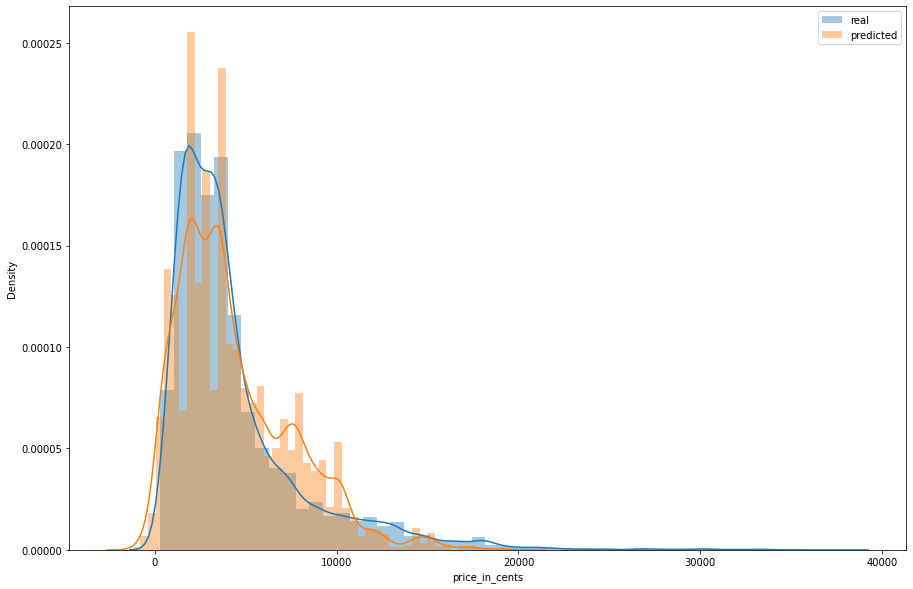

In [69]:
plt.figure(figsize=(15,10))
sns.distplot(y_valid, label = 'real')
sns.distplot(model_lasso.predict(scale(X_valid)), label = 'predicted')
plt.legend(loc='best')
plt.show()

### Modèle réseau de neurones

In [146]:
model_mlp = MLPRegressor(activation='relu', max_iter=100)
model_mlp.fit(X_train, y_train)
print(model_mlp.score(X_train, y_train))
print(model_mlp.score(X_valid, y_valid))
print(0.01*MAE(y_valid, model_mlp.predict(X_valid)))

0.3450203782890381
0.3583721276855737
19.56912194127926


### Modèle Arbres de décisions

In [120]:
# Création et entrainement du modèle XGB
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train, verbose=False)
print(model_xgb.score(X_valid, y_valid))
print(model_xgb.score(X_train, y_train))
print(0.01*MAE(y_valid, model_xgb.predict(X_valid)))

0.9226214599805209
0.9380765507313106
5.663803249265011


C:\Users\flore\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\flore\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


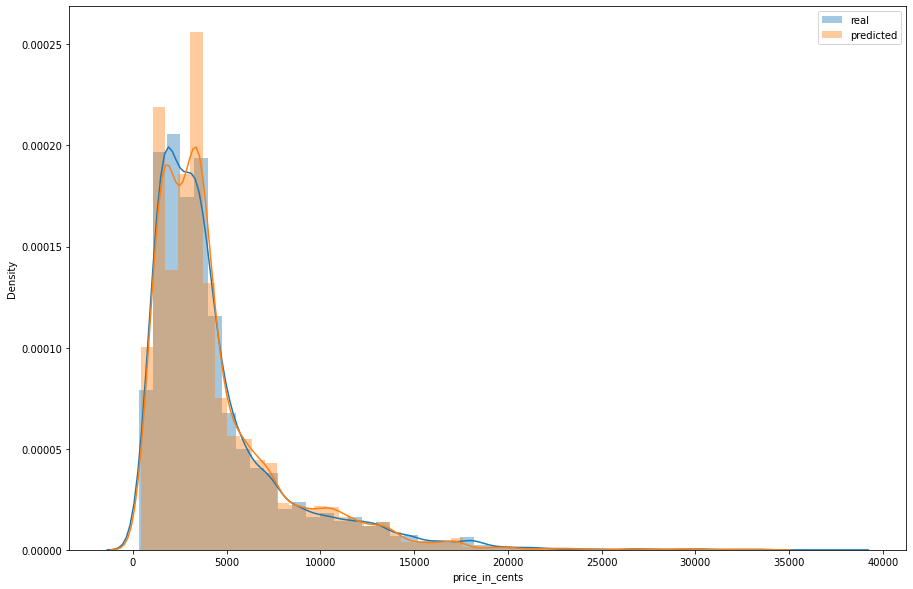

In [121]:
plt.figure(figsize=(15,10))
sns.distplot(y_valid, label = 'real')
sns.distplot(model_xgb.predict(X_valid), label = 'predicted')
plt.legend(loc='best')
plt.show()

### Explicabilité du modèle

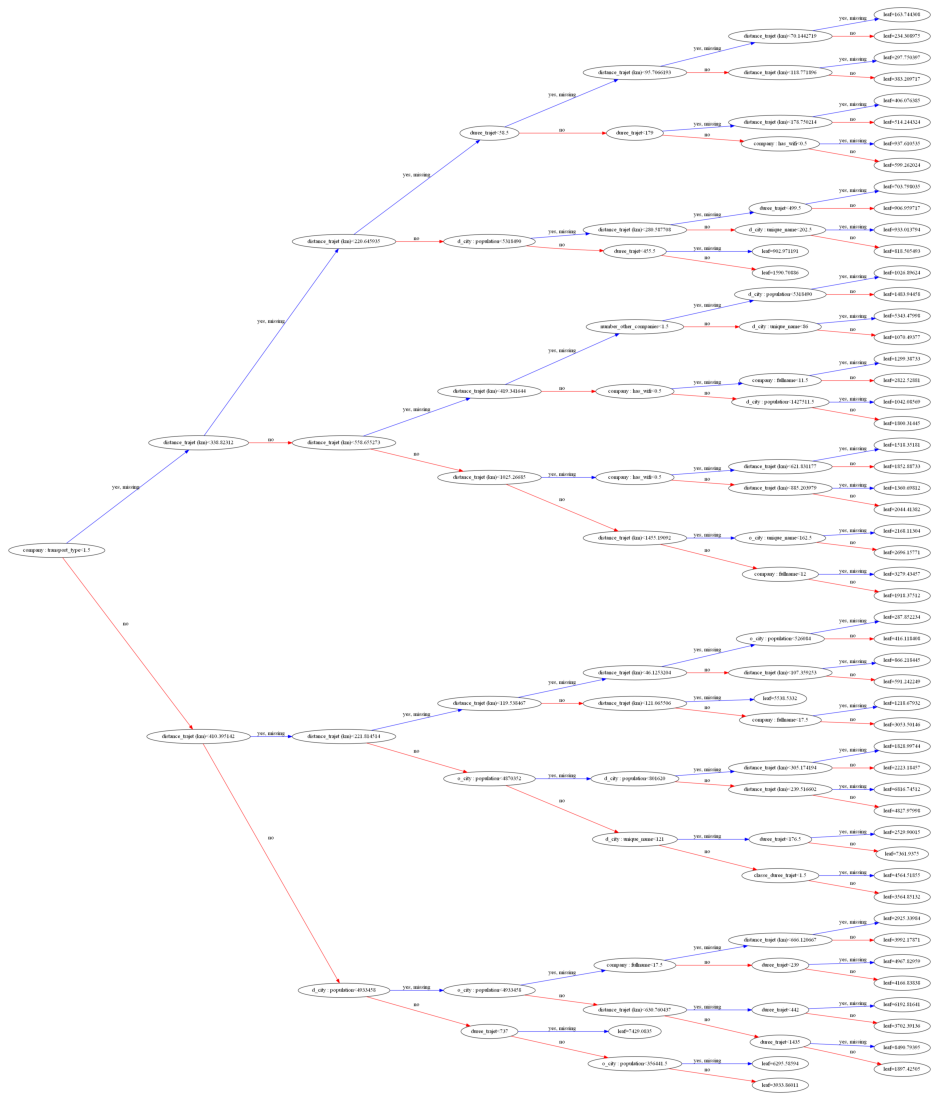

In [123]:
xgb.plot_tree(model_xgb, num_trees=0, rankdir='LR')
plt.rcParams['figure.figsize'] = [20, 10]
plt.savefig('plot_tree_xgb.png')
plt.show()

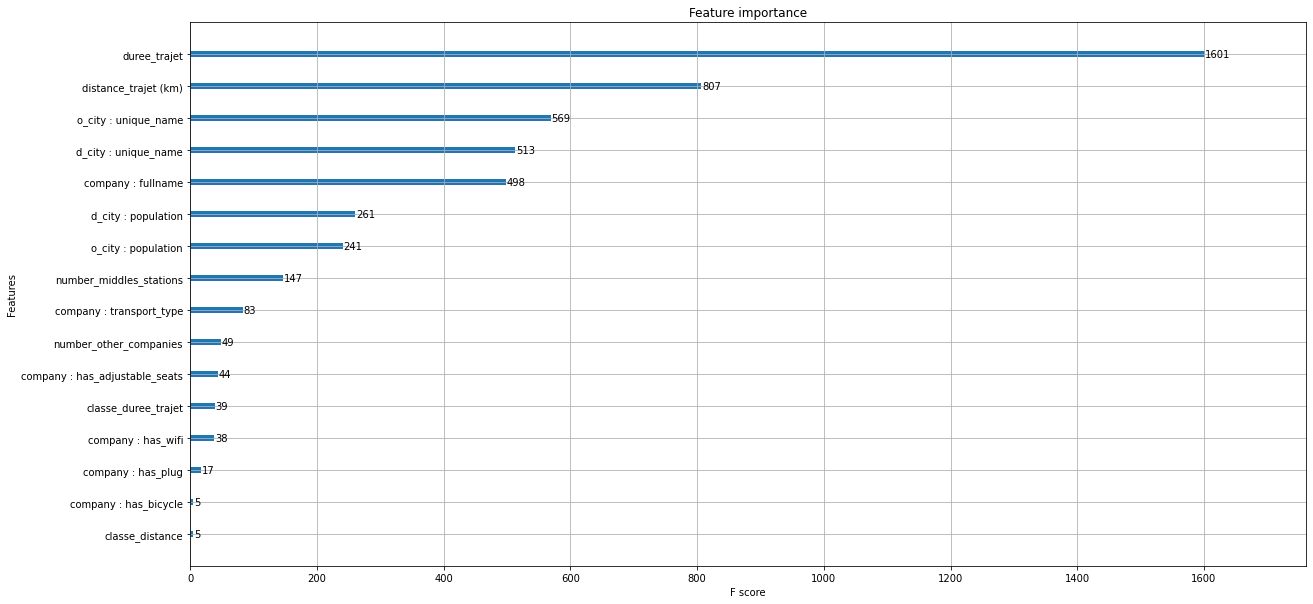

In [122]:
ax = plot_importance(model_xgb)
plt.rcParams['figure.figsize'] = [20, 20]
plt.savefig("plot_importance_xgb.png")
plt.show()

In [130]:
# Création et entrainement du modèle XGB
model_xgb = XGBRegressor()
model_xgb.fit(X_train.values, y_train.values, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

0.2817710025742426


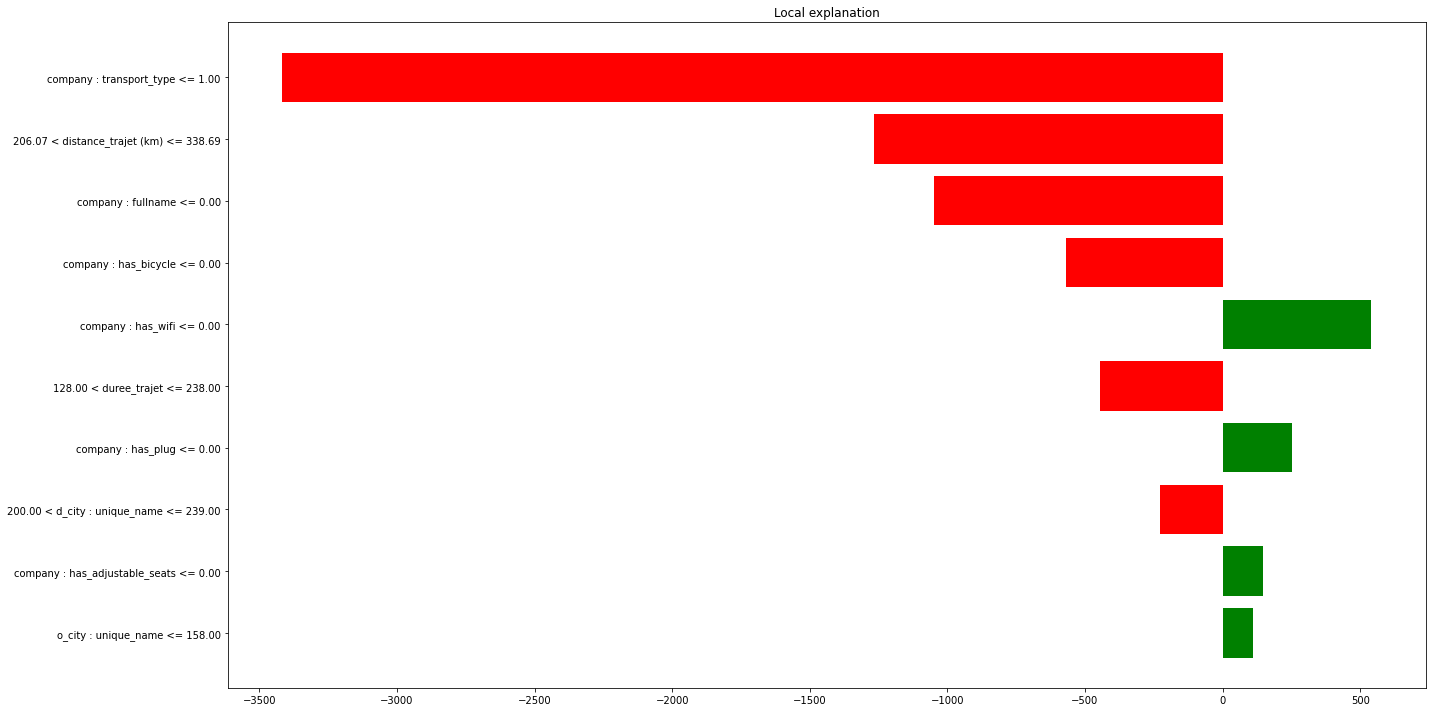

In [145]:
explainer = LimeTabularExplainer(X_train.values, mode="regression", feature_names = X_train.columns)

# Calcul de l'explication LIME
i = 6
X_observation = X_train.iloc[[i],:]

explanation = explainer.explain_instance(X_observation.values[0], model_xgb.predict)
print(explanation.score)

#Affichages
explanation.show_in_notebook(show_table=True, show_all=False)

explanation.as_pyplot_figure()
plt.tight_layout()